In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import glob, os
import xml.etree.ElementTree as ET
%matplotlib widget

def butterworth_filter(data, cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def extract_from_txt(file_path, labels, delimiter='\n'):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    data_dict = {label: [] for label in labels}
    last_delimiter_index = 0
    messages = []
    for i in range(len(lines)):
        if(lines[i].startswith(delimiter)):
            messages.append(lines[last_delimiter_index:i])
            last_delimiter_index = i
    for message in messages:
        message_dict = {label: [] for label in labels}
        for label in labels:
            for line in message:
                    if(line.startswith(label)):
                        message_dict[label].append(float(line.split(':')[1]))
        full = True
        for key in message_dict:
            if(len(message_dict[key]) == 0):
                full=False
                break
        if(full):
            for label in labels:
                data_dict[label].append(message_dict[label][0])

    # for series in data_dict:
    #     print(series, len(data_dict[series]))

    df_raw = pd.DataFrame(data_dict)
    return df_raw

def remove_even_lines(input_file_path, output_file_path):
    with open(input_file_path, 'r') as file:
        lines = file.readlines()
    
    with open(output_file_path, 'w') as file:
        for i, line in enumerate(lines):
            if i % 2 == 0:
                file.write(line)

def extract_fps(xml_string):
    root = ET.fromstring(xml_string)
    video_frame = root.find('.//*[@captureFps][@formatFps]')
    if video_frame is not None:
        capture_fps = str(video_frame.get('captureFps'))
        format_fps = str(video_frame.get('formatFps'))
        return float(capture_fps[:-1]), float(format_fps[:-1])
    else:
        return np.nan, np.nan

XML: ./data/C0027M01.XML
track.csv: ./data/C0027_track.csv
Capture FPS: 479.52
Format FPS: 29.97
playback_speed: 0.0625
frames: 269
t_dxl_start: 113.199
t_vid_liftoff: 0.25025
t_force_liftoff: 4.617325
motoring time: 0.18200000000000216


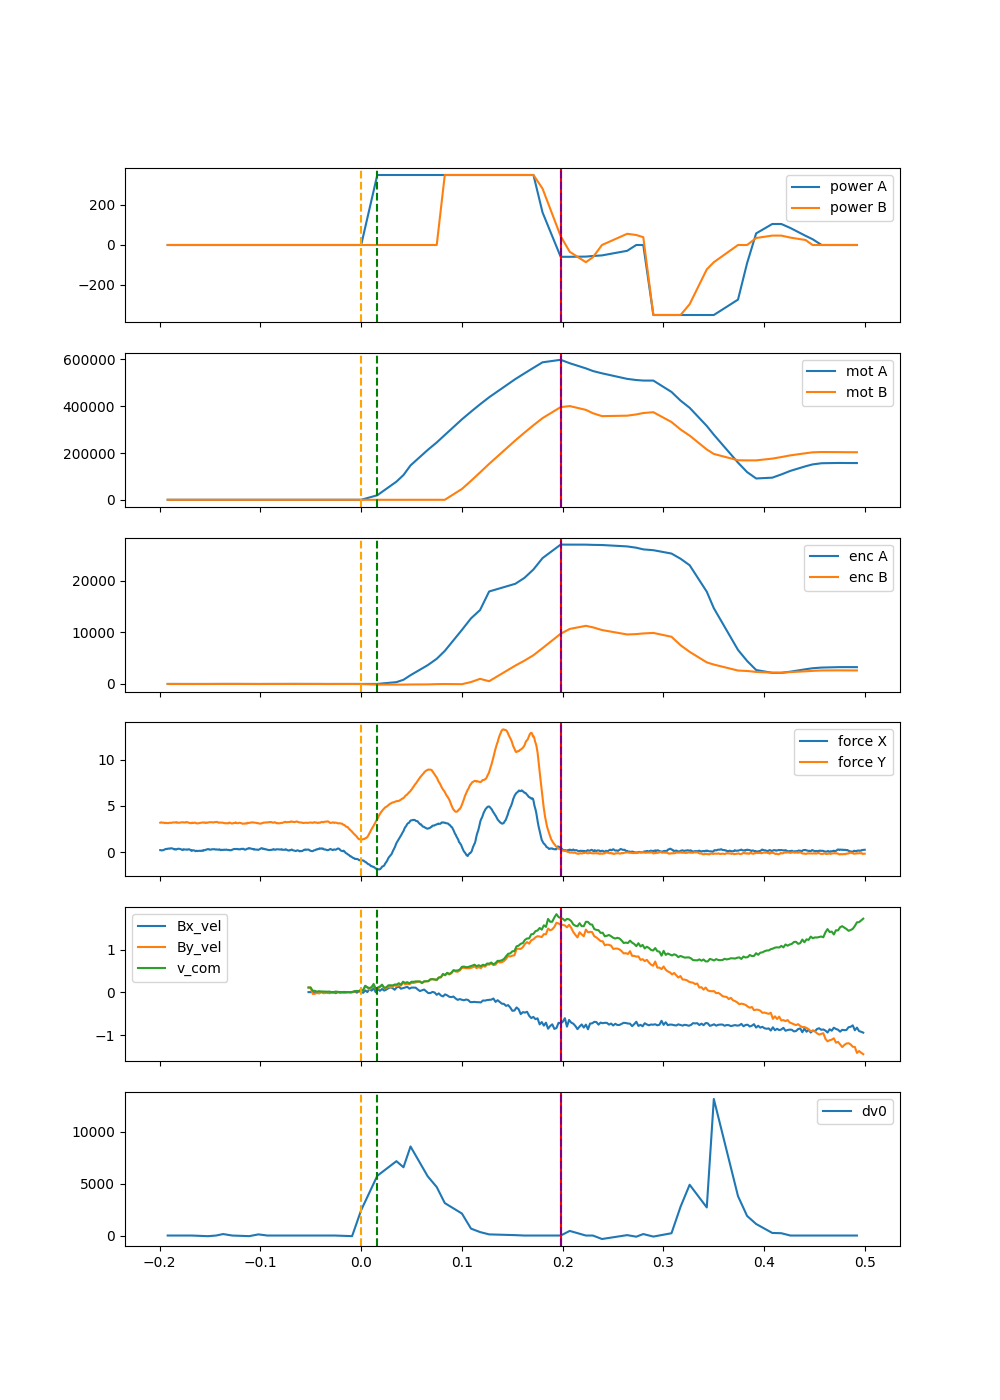

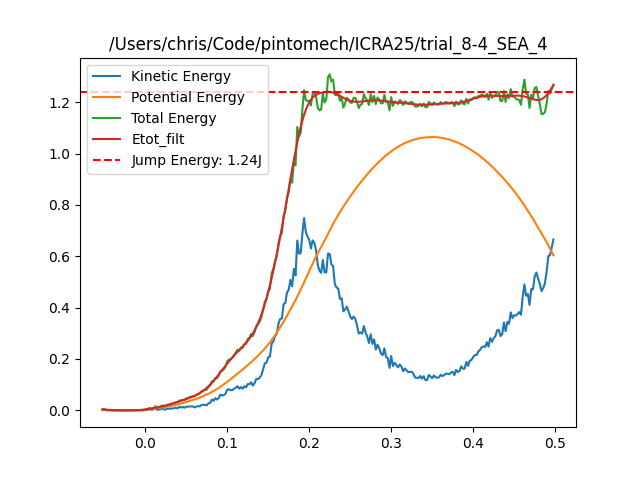

In [36]:
encoder_file = max(glob.glob('./data/*encoder.txt'), key=os.path.getctime)
force_file = max(glob.glob('./data/*force.txt'), key=os.path.getctime)
track_file = max(glob.glob('./data/*track.csv'), key=os.path.getctime)
xml_file = max(glob.glob('./data/*.XML'), key=os.path.getctime)

df_log = extract_from_txt(
    encoder_file, 
    [
        't',
        'pA',
        'pB',
        'mA',
        'mB',
        'eA', 
        'eB', 
        'I',
        'd0',
        'd1',
        'd2',
        'd3',
        'd4',
    ],
    '#'
)

force_data_path = force_file[:-4] + '_filt.txt'
remove_even_lines(force_file, force_data_path)
df_force = extract_from_txt(
    force_data_path, 
    [
        'elapsed',
        'looptime',
        'N23', 
        'N67'
    ],
    '\n'
)

xml_content = open(xml_file, 'r').read()
capture_fps, format_fps = extract_fps(xml_content)
playback_speed = format_fps / capture_fps

print(f"XML: {xml_file}")
print(f"track.csv: {track_file}")
print(f"Capture FPS: {capture_fps}")
print(f"Format FPS: {format_fps}")
print(f"playback_speed: {playback_speed}")

df_vid = pd.read_csv(track_file)
print(f"frames: {len(df_vid)}")


df_log.loc[:,'time'] = df_log.loc[:,'t'] / 1e3
df_log['side_enc_pos'] = df_log['eA'] - df_log['eA'][0]
df_log['center_enc_pos'] = df_log['eB'] - df_log['eB'][0]
df_log['side_mot_pos'] = -(df_log['mA']-df_log['mA'][0])
df_log['center_mot_pos'] = -(df_log['mB']-df_log['mB'][0])
df_log['side_mot_pow'] = -df_log['pA']
df_log['center_mot_pow'] = -df_log['pB']

df_force.loc[:,'time'] = np.cumsum(df_force['looptime']) / 1e6
df_force['Fx'] = -df_force['N23']
df_force['Fy'] = df_force['N67']

df_vid['time'] = df_vid['t'] * playback_speed
df_vid['Bx_vel'] = df_vid['Bx'].diff() / df_vid['time'].diff()
df_vid['By_vel'] = df_vid['By'].diff() / df_vid['time'].diff()
df_vid['Bx_vel'][0] = df_vid['Bx_vel'][1]
df_vid['By_vel'][0] = df_vid['By_vel'][1]
df_vid['v_com'] = np.linalg.norm([df_vid['Bx_vel'], df_vid['By_vel']], axis=0)

df_log['dv0'] = df_log['d0'].diff()/df_log['time'].diff()
i_log_dxl_start = df_log[df_log['dv0'] > 3000].index[0] - 1
t_dxl_start = df_log['time'][i_log_dxl_start]
print(f"t_dxl_start: {t_dxl_start}")

df_vid['By_vel_filt'] = butterworth_filter(df_vid['v_com'], 20, capture_fps)
df_vid['By_acc_filt'] = df_vid['By_vel_filt'].diff() / df_vid['time'].diff()

# i_vid_liftoff = np.where(np.diff(np.sign(df_vid['By_acc_filt'])))[0][-1]

i_vid_liftoff = df_vid['By_vel_filt'].loc[df_vid['By_vel'] > 0].idxmax()
t_vid_liftoff = df_vid['time'][i_vid_liftoff]
print(f"t_vid_liftoff: {t_vid_liftoff}")

df_force['net_force'] = np.sqrt(df_force['Fx']**2 + df_force['Fy']**2)
i_force_liftoff = df_force[df_force['net_force'] > 0.5].index[-1]
t_force_liftoff = df_force['time'][i_force_liftoff]
print(f"t_force_liftoff: {t_force_liftoff}")

i_motorstart = df_log[df_log['side_mot_pow'] > 100].index[0]
t_motor_start = df_log['time'][i_motorstart]

side_enc_thres = max(df_log['side_enc_pos']) - 1000
i_motor_end = df_log[df_log['side_enc_pos'] > side_enc_thres].index[0]
t_motor_end = df_log['time'][i_motor_end]


# synchronize df_log, df_force, and df_vid on the liftoff/motor_end time, but set the zero to t_dxl_start
df_log.loc[:,'time'] = df_log.loc[:,'time'] - t_dxl_start

offset_force_log = t_force_liftoff - t_motor_end
df_force.loc[:,'time'] = df_force.loc[:,'time'] - t_dxl_start - offset_force_log
t_force_liftoff = t_motor_end - t_dxl_start

offset_vid_log = t_vid_liftoff - t_motor_end
df_vid.loc[:,'time'] = df_vid.loc[:,'time'] - t_dxl_start - offset_vid_log
t_vid_liftoff = t_motor_end - t_dxl_start

t_motor_start = t_motor_start - t_dxl_start
t_motor_end = t_motor_end - t_dxl_start

t_dxl_start = 0

time_before = 0.2
time_after = 0.5
df_log = df_log[df_log['time'] >  - time_before]
df_log = df_log[df_log['time'] <  + time_after]
df_log = df_log.reset_index()
df_force = df_force[df_force['time'] >  - time_before]
df_force = df_force[df_force['time'] <  + time_after]
df_force = df_force.reset_index()
df_vid = df_vid[df_vid['time'] >  - time_before]
df_vid = df_vid[df_vid['time'] <  + time_after]
df_vid = df_vid.reset_index()



#rezero after the time range
df_log['side_enc_pos'] = df_log['eA'] - df_log['eA'][0]
df_log['center_enc_pos'] = df_log['eB'] - df_log['eB'][0]
df_log['side_mot_pos'] = -(df_log['mA']-df_log['mA'][0])
df_log['center_mot_pos'] = -(df_log['mB']-df_log['mB'][0])

fig, axs = plt.subplots(6,1,figsize=(10,14), sharex=True)
axs[0].plot(df_log['time'], df_log['side_mot_pow'], label='power A')
axs[0].plot(df_log['time'], df_log['center_mot_pow'], label='power B')
axs[1].plot(df_log['time'], df_log['side_mot_pos'], label='mot A')
axs[1].plot(df_log['time'], df_log['center_mot_pos'], label='mot B')
axs[2].plot(df_log['time'], df_log['side_enc_pos'], label='enc A')
axs[2].plot(df_log['time'], df_log['center_enc_pos'], label='enc B')
axs[3].plot(df_force['time'], df_force['Fx'], label='force X')
axs[3].plot(df_force['time'], df_force['Fy'], label='force Y')
axs[4].plot(df_vid['time'], df_vid['Bx_vel'], label='Bx_vel')
axs[4].plot(df_vid['time'], df_vid['By_vel'], label='By_vel')
axs[4].plot(df_vid['time'], df_vid['v_com'], label='v_com')
# axs[4].plot(df_vid['time'], df_vid['By_acc_filt'], label='By_acc')
axs[5].plot(df_log['time'], df_log['dv0'], label='dv0')
# axs[5].plot(df_log['time'], df_log['d1'], label='d1')
# axs[5].plot(df_log['time'], df_log['d2'], label='d2')
# axs[5].plot(df_log['time'], df_log['d3'], label='d3')
# axs[5].plot(df_log['time'], df_log['d4'], label='d4')
# axs[5].plot(df_vid['time'], df_vid['By'], label='By')
for ax in axs:
    ax.legend()


for ax in axs:
    # ax.axvline(x=force_thres_t - offset, color='r', linestyle='--')
    # ax.axvline(x=enc_thres_t, color='b', linestyle='--')

    ax.axvline(x=t_dxl_start, color='orange', linestyle='--')
    ax.axvline(x=t_motor_start, color='g', linestyle='--')
    ax.axvline(x=t_force_liftoff, color='r', linestyle='-')
    ax.axvline(x=t_motor_end, color='purple', linestyle='--')

print(f"motoring time: {t_motor_end - t_motor_start}")


m = 0.450
g = 9.81

KE = 0.5*m*df_vid['v_com']**2
PE = m*g*(df_vid['By'] - df_vid['By'][0])
PE.loc[PE < 0] = 0
E_tot = KE + PE
E_tot_filt = butterworth_filter(E_tot, 20, capture_fps)

max_E_tot = max(E_tot_filt[10:-10])

# v_com

plt.figure()
directory_name = os.path.abspath("")
plt.title(directory_name)
plt.plot(df_vid['time'], KE, label='Kinetic Energy')
plt.plot(df_vid['time'], PE, label='Potential Energy')
plt.plot(df_vid['time'], E_tot, label='Total Energy')
plt.plot(df_vid['time'], E_tot_filt, label='Etot_filt')
plt.axhline(y=max_E_tot, color='r', linestyle='--', label=f'Jump Energy: {max_E_tot:.3}J')
plt.legend()


In [35]:
plt.close('all')

No such comm: 96c5264249784275be7904eb3e84a319
No such comm: 48932581268343589fdd2eceb2b3a1d3
